In [0]:
%matplotlib inline

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time

In [0]:
%ls

drive/  sample_data/


In [3]:
cd /content/drive/My Drive/Denoising_project

/content/drive/My Drive/Denoising_project


In [0]:
dataset_root_dir = 'BSDS300/images'

In [0]:
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')   
        # random crop
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            # convert it to a tensor
            tv.transforms.ToTensor(),
            # normalize it to the range [−1, 1]
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            ])
        clean = transform(clean)
        
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

In [0]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [0]:
train_set = NoisyBSDSDataset(dataset_root_dir)
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320))

image size is torch.Size([3, 320, 320]).


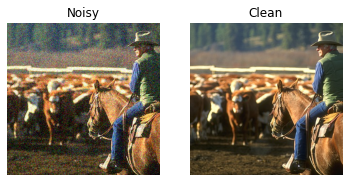

In [0]:
x = test_set[12]
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')
print(f'image size is {x[0].shape}.')


In [0]:
"""
Neural Network tools developed for UCSD ECE285 MLIP.

Copyright 2019. Charles Deledalle, Sneha Gupta, Anurag Paul, Inderjot Saggu.
"""

import os
import time
import torch
from torch import nn
import torch.utils.data as td
from abc import ABC, abstractmethod


class NeuralNetwork(nn.Module, ABC):
    

    def __init__(self):
        super(NeuralNetwork, self).__init__()

    @property
    def device(self):
        # This is important that this is a property and not an attribute as the
        # device may change anytime if the user do ``net.to(newdevice)``.
        return next(self.parameters()).device

    def named_parameters(self, recurse=True):
        nps = nn.Module.named_parameters(self)
        for name, param in nps:
            if not param.requires_grad:
                continue
            yield name, param

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def criterion(self, y, d):
        pass


class StatsManager(object):
    

    def __init__(self):
        self.init()

    def __repr__(self):
       
        return self.__class__.__name__

    def init(self):
        """Initialize/Reset all the statistics"""
        self.running_loss = 0
        self.number_update = 0

    def accumulate(self, loss, x=None, y=None, d=None):
        
        self.running_loss += loss
        self.number_update += 1

    def summarize(self):
        """Compute statistics based on accumulated ones"""
        return self.running_loss / self.number_update


class Experiment(object):
       
    def __init__(self, net, train_set, val_set, optimizer, stats_manager,
                 output_dir=None, batch_size=16, perform_validation_during_training=False):

        # Define data loaders
        train_loader = td.DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                     drop_last=True, pin_memory=True)
        val_loader = td.DataLoader(val_set, batch_size=batch_size, shuffle=False,
                                   drop_last=True, pin_memory=True)

        # Initialize history
        history = []

        # Define checkpoint paths
        if output_dir is None:
            output_dir = 'experiment_{}'.format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        config_path = os.path.join(output_dir, "config.txt")

        # Transfer all local arguments/variables into attributes
        locs = {k: v for k, v in locals().items() if k is not 'self'}
        self.__dict__.update(locs)

        # Load checkpoint and check compatibility
        if os.path.isfile(config_path):
            with open(config_path, 'r') as f:
                if f.read()[:-1] != repr(self):
                    raise ValueError(
                        "Cannot create this experiment: "
                        "I found a checkpoint conflicting with the current setting.")
            self.load()
        else:
            self.save()

    @property
    def epoch(self):
        """Returns the number of epochs already performed."""
        return len(self.history)

    def setting(self):
        """Returns the setting of the experiment."""
        return {'Net': self.net,
                'TrainSet': self.train_set,
                'ValSet': self.val_set,
                'Optimizer': self.optimizer,
                'StatsManager': self.stats_manager,
                'BatchSize': self.batch_size,
                'PerformValidationDuringTraining': self.perform_validation_during_training}

    def __repr__(self):
        string = ''
        for key, val in self.setting().items():
            string += '{}({})\n'.format(key, val)
        return string

    def state_dict(self):
        """Returns the current state of the experiment."""
        return {'Net': self.net.state_dict(),
                'Optimizer': self.optimizer.state_dict(),
                'History': self.history}

    def load_state_dict(self, checkpoint):
        """Loads the experiment from the input checkpoint."""
        self.net.load_state_dict(checkpoint['Net'])
        self.optimizer.load_state_dict(checkpoint['Optimizer'])
        self.history = checkpoint['History']

        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(self.net.device)

    def save(self):
        """Saves the experiment on disk, i.e, create/update the last checkpoint."""
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)

    def load(self):
        """Loads the experiment from the last checkpoint saved on disk."""
        checkpoint = torch.load(self.checkpoint_path,
                                map_location=self.net.device)
        self.load_state_dict(checkpoint)
        del checkpoint

    def run(self, num_epochs, plot=None):
        
        self.net.train()
        self.stats_manager.init()
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
        if plot is not None:
            plot(self)
        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            self.stats_manager.init()
            for x, d in self.train_loader:
                x, d = x.to(self.net.device), d.to(self.net.device)
                self.optimizer.zero_grad()
                y = self.net.forward(x)
                loss = self.net.criterion(y, d)
                loss.backward()
                self.optimizer.step()
                with torch.no_grad():
                    self.stats_manager.accumulate(loss.item(), x, y, d)
            if not self.perform_validation_during_training:
                self.history.append(self.stats_manager.summarize())
                print("Epoch {} | Time: {:.2f}s | Training Loss: {:.6f}".format(
                    self.epoch, time.time() - s, self.history[-1][0]['loss']))
            else:
                self.history.append(
                    (self.stats_manager.summarize(), self.evaluate()))
                print("Epoch {} | Time: {:.2f}s | Training Loss: {:.6f} | Evaluation Loss: {:.6f}".format(
                    self.epoch, time.time() - s, self.history[-1][0]['loss'], self.history[-1][1]['loss']))
            
            self.save()
            if plot is not None:
                plot(self)
        print("Finish training for {} epochs".format(num_epochs))

    def evaluate(self):
        
        self.stats_manager.init()
        self.net.eval()
        with torch.no_grad():
            for x, d in self.val_loader:
                x, d = x.to(self.net.device), d.to(self.net.device)
                y = self.net.forward(x)
                loss = self.net.criterion(y, d)
                self.stats_manager.accumulate(loss.item(), x, y, d)
        self.net.train()
        return self.stats_manager.summarize()

In [0]:
class NNRegressor(NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

Deep Denoising CNN

In [0]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y

In [0]:
class DenoisingStatsManager(StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

In [0]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[None])[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    #pdb.set_trace()
    print('PSNR = {}'.format(exp.history[exp.epoch-1][0]['PSNR']))
    plt.tight_layout()
    fig.canvas.draw()

In [0]:
lr = 1e-3
net = DnCNN(6)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="checkpoints/denoising1", perform_validation_during_training=True)

Start/Continue training from epoch 4
PSNR = 23.101537704467773
Epoch 5 | Time: 485.25s | Training Loss: 0.017703 | Evaluation Loss: 0.016365
Epoch 6 | Time: 188.97s | Training Loss: 0.015958 | Evaluation Loss: 0.014982
PSNR = 24.00774383544922
Epoch 7 | Time: 186.42s | Training Loss: 0.014384 | Evaluation Loss: 0.013758
Epoch 8 | Time: 187.91s | Training Loss: 0.013672 | Evaluation Loss: 0.012843
PSNR = 24.68447494506836
Epoch 9 | Time: 187.36s | Training Loss: 0.012534 | Evaluation Loss: 0.012015
Epoch 10 | Time: 186.79s | Training Loss: 0.011644 | Evaluation Loss: 0.011292
PSNR = 25.381616592407227
Epoch 11 | Time: 188.28s | Training Loss: 0.011109 | Evaluation Loss: 0.010724
Epoch 12 | Time: 190.88s | Training Loss: 0.010701 | Evaluation Loss: 0.010243
PSNR = 25.74651336669922
Epoch 13 | Time: 185.61s | Training Loss: 0.010171 | Evaluation Loss: 0.010044
Epoch 14 | Time: 185.25s | Training Loss: 0.009868 | Evaluation Loss: 0.009515
PSNR = 26.1043701171875
Epoch 15 | Time: 184.47s | 

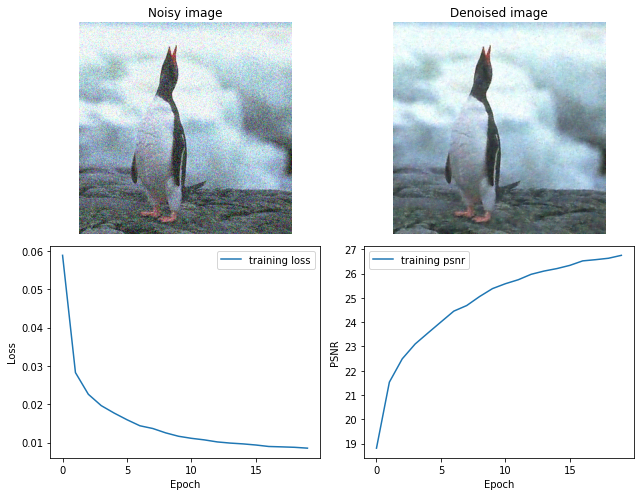

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

Dilated Denoising CNN

In [0]:
class DUDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        
        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # holes and dilations for convolution layers
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            h_buff.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        y = self.conv[D+1](h) + x
        return y

In [0]:
lr = 1e-3
net = DUDnCNN(6)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="../checkpoints/denoising3", perform_validation_during_training=True)

Start/Continue training from epoch 20
PSNR = 27.432828903198242
Epoch 21 | Time: 714.26s | Training Loss: 0.007225 | Evaluation Loss: 0.007109
Finish training for 21 epochs


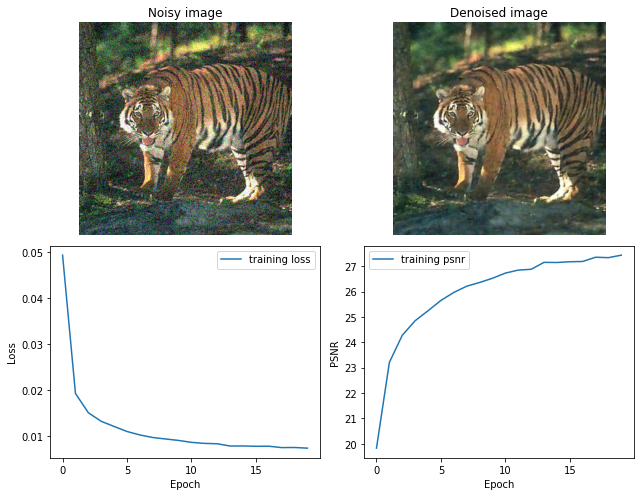

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp3.run(num_epochs=21, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[74][0]))

Multi Column Dilated CNN

In [0]:
import pdb
class MDCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(MDCNN, self).__init__()
        self.D = D
        
        # convolution layers
        # pdb.set_trace()
        self.conv1 = nn.ModuleList()
        self.conv2 = nn.ModuleList()
        self.first_conv = nn.Conv2d(3, C, 3, padding=1)
        #self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        
        self.conv1.extend([nn.Conv2d(C, int(C/2), 3, padding=1,dilation=1) for _ in range(D)])
        self.conv2.extend([nn.Conv2d(C, int(C/2), 3, padding=2,dilation=2) for _ in range(D)])
        #self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        self.last_conv= nn.Conv2d(C, 3, 3, padding=1)
        # apply He's initialization
        for i in range(len(self.conv1[:-1])):
            nn.init.kaiming_normal_(self.conv1[i].weight.data, nonlinearity='relu')
        
        for i in range(len(self.conv2[:-1])):
            nn.init.kaiming_normal_(self.conv2[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.first_conv(x))
        for i in range(D):
            #pdb.set_trace()
            h = F.relu(self.bn[i](torch.cat((self.conv1[i](h),self.conv2[i](h)),1)))
        y = self.last_conv(h) + x
        return y

In [0]:
lr = 1e-3
net = MDCNN(6)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp4 = Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="../checkpoints/denoising7", perform_validation_during_training=True)

Start/Continue training from epoch 20
PSNR = 28.518171310424805
Epoch 21 | Time: 370.79s | Training Loss: 0.005684 | Evaluation Loss: 0.005996
Finish training for 21 epochs


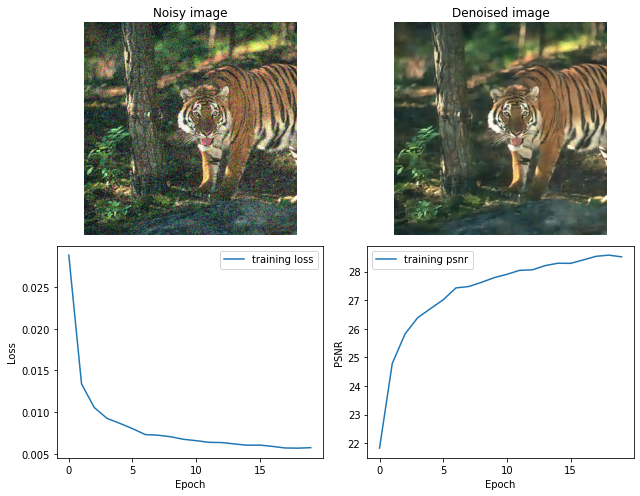

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp4.run(num_epochs=21, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[74][0]))

In [0]:
import pdb
class MDCNN(NNRegressor):

    def __init__(self, D, C=256):
        super(MDCNN, self).__init__()
        self.D = D
        
        # convolution layers
        # pdb.set_trace()
        self.conv1 = nn.ModuleList()
        self.conv2 = nn.ModuleList()
        self.conv3 = nn.ModuleList()
        self.first_conv = nn.Conv2d(3, C, 3, padding=1)
        #self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        
        self.conv1.extend([nn.Conv2d(C, int(C/2), 3, padding=1,dilation=1) for _ in range(D)])
        self.conv2.extend([nn.Conv2d(C, int(C/4), 3, padding=2,dilation=2) for _ in range(D)])
        self.conv3.extend([nn.Conv2d(C, int(C/4), 3, padding=3,dilation=3) for _ in range(D)])
        #self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        self.last_conv= nn.Conv2d(C, 3, 3, padding=1)
        # apply He's initialization
        for i in range(len(self.conv1[:-1])):
            nn.init.kaiming_normal_(self.conv1[i].weight.data, nonlinearity='relu')
        
        for i in range(len(self.conv2[:-1])):
            nn.init.kaiming_normal_(self.conv2[i].weight.data, nonlinearity='relu')
        
        for i in range(len(self.conv3[:-1])):
            nn.init.kaiming_normal_(self.conv3[i].weight.data, nonlinearity='relu')
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.first_conv(x))
        for i in range(D):
            #pdb.set_trace()
            h = F.relu(self.bn[i](torch.cat((self.conv1[i](h),self.conv2[i](h),self.conv3[i](h)),1)))
        y = self.last_conv(h) + x
        return y

In [86]:
exp4.history[exp4.epoch-1][0]['PSNR']

IndexError: ignored